# RMSE函数

In [25]:
import numpy as np
import pandas as pd

def calculate_rmse_and_std_for_years(model_data, observed_data, years=[2010, 2015, 2020]):
    """
    计算模型数据与观测数据在指定年份的 RMSE、标准差、偏差等统计指标。

    参数:
        model_data (pd.DataFrame): 模型数据，索引为 (Model, Scenario, Variable)，列为年份等信息。
        observed_data (pd.DataFrame): 观测数据，结构与 model_data 相同。
        years (list of int): 需要计算的年份列表。

    返回:
        dict: 每个 (Model, Scenario, Variable) 对应一个字典，包含以下字段：
              'RMSE', 'STD', 'NORMAL_RMSE', 'BIAS', 'NORMAL_bias',
              'CENTERED_RMSE', 'C_NORMAL_RMSE'
    """
    results = {}

    for index in model_data.index.unique():
        rmse_list = []
        std_list = []
        mval_list = []
        msed_list = []

        for year in years:
            year = str(year)
            if year not in model_data.columns or year not in observed_data.columns:
                continue

            model_val = model_data.loc[index, year]
            observed_val = observed_data.loc[index, year]

            if pd.isna(model_val) or pd.isna(observed_val):
                continue

            mse = (model_val - observed_val) ** 2
            mse_d = model_val - observed_val
            rmse = np.sqrt(mse)

            rmse_list.append(rmse)
            std_list.append(observed_val)
            mval_list.append(model_val)
            msed_list.append(mse_d)

        if rmse_list:
            rmse_avg = np.nanmean(rmse_list)
            std_values = np.array(std_list).flatten()
            std_avg = np.nanstd(std_values)
            mval_values = np.array(mval_list).flatten()
            msed_values = np.array(msed_list).flatten()

            aligned_mval_values = mval_values[:len(std_values)]
            bias = np.nanmean(aligned_mval_values) - np.nanmean(std_values)
            normal_bias = bias / std_avg if std_avg != 0 else np.nan

            squared_values = [((v - bias) ** 2 if v != 0 else 0) for v in msed_values]
            c_mse = np.nanmean(squared_values)
            c_rmse = np.sqrt(c_mse)
            normal_rmse = rmse_avg / std_avg if std_avg != 0 else np.nan
            normal_crmse = c_rmse / std_avg if std_avg != 0 else np.nan

            results[index] = {
                'RMSE': rmse_avg,
                'STD': std_avg,
                'NORMAL_RMSE': normal_rmse,
                'BIAS': bias,
                'NORMAL_bias': normal_bias,
                'CENTERED_RMSE': c_rmse,
                'C_NORMAL_RMSE': normal_crmse
            }

    return results

# 实际计算RMSE

In [26]:
# 读取 Excel 文件
model_data = pd.read_excel(
    r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\calculated_data\modal_data.xlsx"
).set_index(['Model', 'Scenario', 'Variable'])

observed_data = pd.read_excel(
    r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\calculated_data\observed_data.xlsx"
).set_index(['Model', 'Scenario', 'Variable'])

# 确保年份列为字符串格式
model_data.columns = model_data.columns.map(str)
observed_data.columns = observed_data.columns.map(str)

# 运行计算函数
results = calculate_rmse_and_std_for_years(model_data, observed_data)
print(f"成功计算的条目数：{len(results)}")

成功计算的条目数：10403


In [27]:
# 构建结果 DataFrame
df = pd.DataFrame(list(results.keys()), columns=['Model', 'Scenario', 'Variable'])
df['RMSE'] = [result['RMSE'] for result in results.values()]
df['STD'] = [result['STD'] for result in results.values()]
df['NORMAL_RMSE'] = [result['NORMAL_RMSE'] for result in results.values()]
df['BIAS'] = [result['BIAS'] for result in results.values()]
df['CENTERED_RMSE'] = [result['CENTERED_RMSE'] for result in results.values()]
df['C_NORMAL_RMSE'] = [result['C_NORMAL_RMSE'] for result in results.values()]
df['NORMAL_bias'] = [result['NORMAL_bias'] for result in results.values()]

# 输出 CSV 文件
output_path = r'C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\results\rms_results_4models.csv'
df.to_csv(output_path, index=False)

print(f"结果已保存至：{output_path}")

结果已保存至：C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\results\rms_results_4models.csv


In [28]:

# 读取原始 RMSE 结果数据
df = pd.read_csv(r'C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\results\rms_results_4models.csv')

# 替换正负无穷为 NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 分组并计算每组（Model, Variable）的平均指标
result = df.groupby(['Model', 'Variable']).agg({
    'RMSE': lambda x: x.mean(skipna=True),
    'STD': lambda x: x.mean(skipna=True),
    'NORMAL_RMSE': lambda x: x.mean(skipna=True),
    'BIAS': lambda x: x.mean(skipna=True),
    'CENTERED_RMSE': lambda x: x.mean(skipna=True),      # ✅ 修正拼写
    'C_NORMAL_RMSE': lambda x: x.mean(skipna=True),
    'NORMAL_bias': lambda x: x.mean(skipna=True)
}).reset_index()

# 保存结果为 CSV 文件
result.to_csv(
    r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\results\error_metrics_avg_4models.csv",
    index=False
)

print("已成功保存分组后的平均误差指标。")

已成功保存分组后的平均误差指标。


In [29]:
import pandas as pd

# 使用原始字符串避免路径转义问题
file_path = r'C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\results\error_metrics_avg_4models.csv'

try:
    # 尝试读取 CSV 文件
    data = pd.read_csv(file_path)
    
    # 显示前几行数据以确认结构
    print("文件读取成功，预览前五行：")
    display(data.head())

except FileNotFoundError:
    print(f"文件未找到，请确认路径是否正确：\n{file_path}")
except Exception as e:
    print(f"读取文件时发生错误：{e}")

文件读取成功，预览前五行：


,Model,Variable,RMSE,STD,NORMAL_RMSE,BIAS,CENTERED_RMSE,C_NORMAL_RMSE,NORMAL_bias
0,AIM/CGE 2.1,Capacity|Electricity,559.956644,505.208827,1.108367,-559.956644,275.840304,0.545993,-1.108367
1,AIM/CGE 2.1,Capacity|Electricity|Biomass,0.819858,0.164462,4.985076,0.819858,0.076675,0.466216,4.985076
2,AIM/CGE 2.1,Capacity|Electricity|Coal,530.191001,3.906134,135.732918,530.191001,97.086615,24.854910,135.732918
3,AIM/CGE 2.1,Capacity|Electricity|Gas,6.638499,0.256509,25.880137,6.638499,1.595074,6.218383,25.880137
4,AIM/CGE 2.1,Capacity|Electricity|Hydro,275.912152,0.912308,302.433276,275.912152,66.634645,73.039675,302.433276


In [30]:
import pandas as pd

# 读取数据
file_path = r'C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\results\error_metrics_avg_4models.csv'
data = pd.read_csv(file_path)

# 计算每个 Variable 的 NORMAL_bias 样本标准差
std_per_variable = data.groupby('Variable')['NORMAL_bias'].std()

# 定义分类函数
def classify_data(row, std_dev):
    lower_bound = -0.5 * std_dev
    upper_bound = 0.5 * std_dev
    if row['NORMAL_bias'] < lower_bound:
        return 'Low'
    elif row['NORMAL_bias'] > upper_bound:
        return 'High'
    else:
        return 'Medium'

# 应用分类
data['Classification'] = data.apply(
    lambda row: classify_data(row, std_per_variable.get(row['Variable'], 0)),
    axis=1
)

# 预览分类结果
print("分类结果预览：")
display(data[['Variable', 'NORMAL_bias', 'Classification']].head())

# 保存为新文件（路径已更新）
updated_file_path = r'C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\results\rmse_results_models_average.csv'
data.to_csv(updated_file_path, index=False)

print(f"✅ 结果已保存至：{updated_file_path}")

分类结果预览：


,Variable,NORMAL_bias,Classification
0,Capacity|Electricity,-1.108367,Low
1,Capacity|Electricity|Biomass,4.985076,Medium
2,Capacity|Electricity|Coal,135.732918,High
3,Capacity|Electricity|Gas,25.880137,Medium
4,Capacity|Electricity|Hydro,302.433276,High


✅ 结果已保存至：C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\results\rmse_results_models_average.csv


# NORMAL_bias&Classification制表

In [36]:
import pandas as pd
import os

# 输入路径与输出配置
input_path = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\results\origin_results\rmse_results_models_average.csv"
output_dir = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\results\NORMAL_bias_Classification_table"
output_file = os.path.join(output_dir, "NORMAL_bias_Classification_table.csv")

# 确保输出文件夹存在
os.makedirs(output_dir, exist_ok=True)

# 读取数据
data = pd.read_csv(input_path)

# 格式化字符串：上方为分类，下方为 NORMAL_bias 值（保留两位小数，强制显示 .00）
data['Formatted'] = data.apply(
    lambda row: f"{row['Classification']}\n({row['NORMAL_bias']:.2f})",
    axis=1
)

# 创建透视表：Model 为行，Variable 为列，值为格式化后的字符串
pivot_table = data.pivot(index='Model', columns='Variable', values='Formatted')

# 保存为 CSV 文件（utf-8-sig 编码兼容中文和 Excel）
pivot_table.to_csv(output_file, encoding='utf-8-sig')

In [37]:
import pandas as pd
import os

# 1. 翻译字典：英文 → 中文（保留变量层级结构）
translation_dict = {
    "Capacity": "产能",
    "Electricity": "电力",
    "Biomass": "生物质",
    "Coal": "煤炭",
    "Gas": "天然气",
    "Hydro": "水电",
    "Nuclear": "核能",
    "Oil": "石油",
    "Solar": "太阳能",
    "Wind": "风能",
    "Emissions": "排放",
    "CO2": "二氧化碳",
    "Kyoto Gases": "京都温室气体",
    "Final Energy": "最终能源",
    "Industry": "工业",
    "Residential and Commercial": "居民和商业",
    "Transportation": "交通",
    "GDP": "国内生产总值",
    "MER": "市场汇率",
    "Population": "人口",
    "Primary Energy": "一次能源",
    "Fossil": "化石能源",
    "Secondary Energy": "二次能源"
}

# 2. 输入输出路径
input_file = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\results\NORMAL_bias_Classification_table\NORMAL_bias_Classification_table.csv"
output_file = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\results\NORMAL_bias_Classification_table\NORMAL_bias_Classification_table_translated.csv"

# 3. 读取原始数据
df = pd.read_csv(input_file, encoding='utf-8-sig')

# 4. 替换列名
translated_columns = []
for col in df.columns:
    if col == "Model":
        translated_columns.append(col)
    else:
        parts = col.split('|')
        translated_parts = [translation_dict.get(part.strip(), part) for part in parts]
        translated_column = '|'.join(translated_parts)
        translated_columns.append(translated_column)

df.columns = translated_columns

# 5. 保存为新文件
df.to_csv(output_file, index=False, encoding='utf-8-sig')

# 圆环散点图（Normal RMSE & Normal Centered RMSE）_非极度偏倚

## 模型输入的历史误差

### 合并文件

In [2]:
import pandas as pd

# 路径
file1 = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\calculated_data\Normal_Centered_RMSE\非极度偏倚\模型输入的历史误差_非极度偏倚.xlsx"
file2 = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\results\origin_results\rmse_results_models_average.csv"
output = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\calculated_data\Normal_Centered_RMSE\非极度偏倚\模型输入的历史误差_非极度偏倚_画图.csv"

# 读取数据
df1 = pd.read_excel(file1)
df2 = pd.read_csv(file2)

# 假设NORMAL_bias在df2中，如果不叫这个名字请用实际列名
# 合并，默认inner会保留两边都匹配的行，如果要保留左表全部，用left
merged = pd.merge(df1, df2[['Model', 'Variable', 'NORMAL_bias']], on=['Model', 'Variable'], how='left')

# 用df2的NORMAL_bias列替换df1的NORMAL_bias列（如果df1本来有这个列）
merged['NORMAL_bias'] = merged['NORMAL_bias_y'].combine_first(merged['NORMAL_bias_x'])
# 或者直接保留merge后的NORMAL_bias列
merged = merged.drop(columns=[col for col in merged.columns if col.endswith('_x') or col.endswith('_y')])

# 保存为csv
merged.to_csv(output, index=False, encoding='utf-8-sig')

### 画图

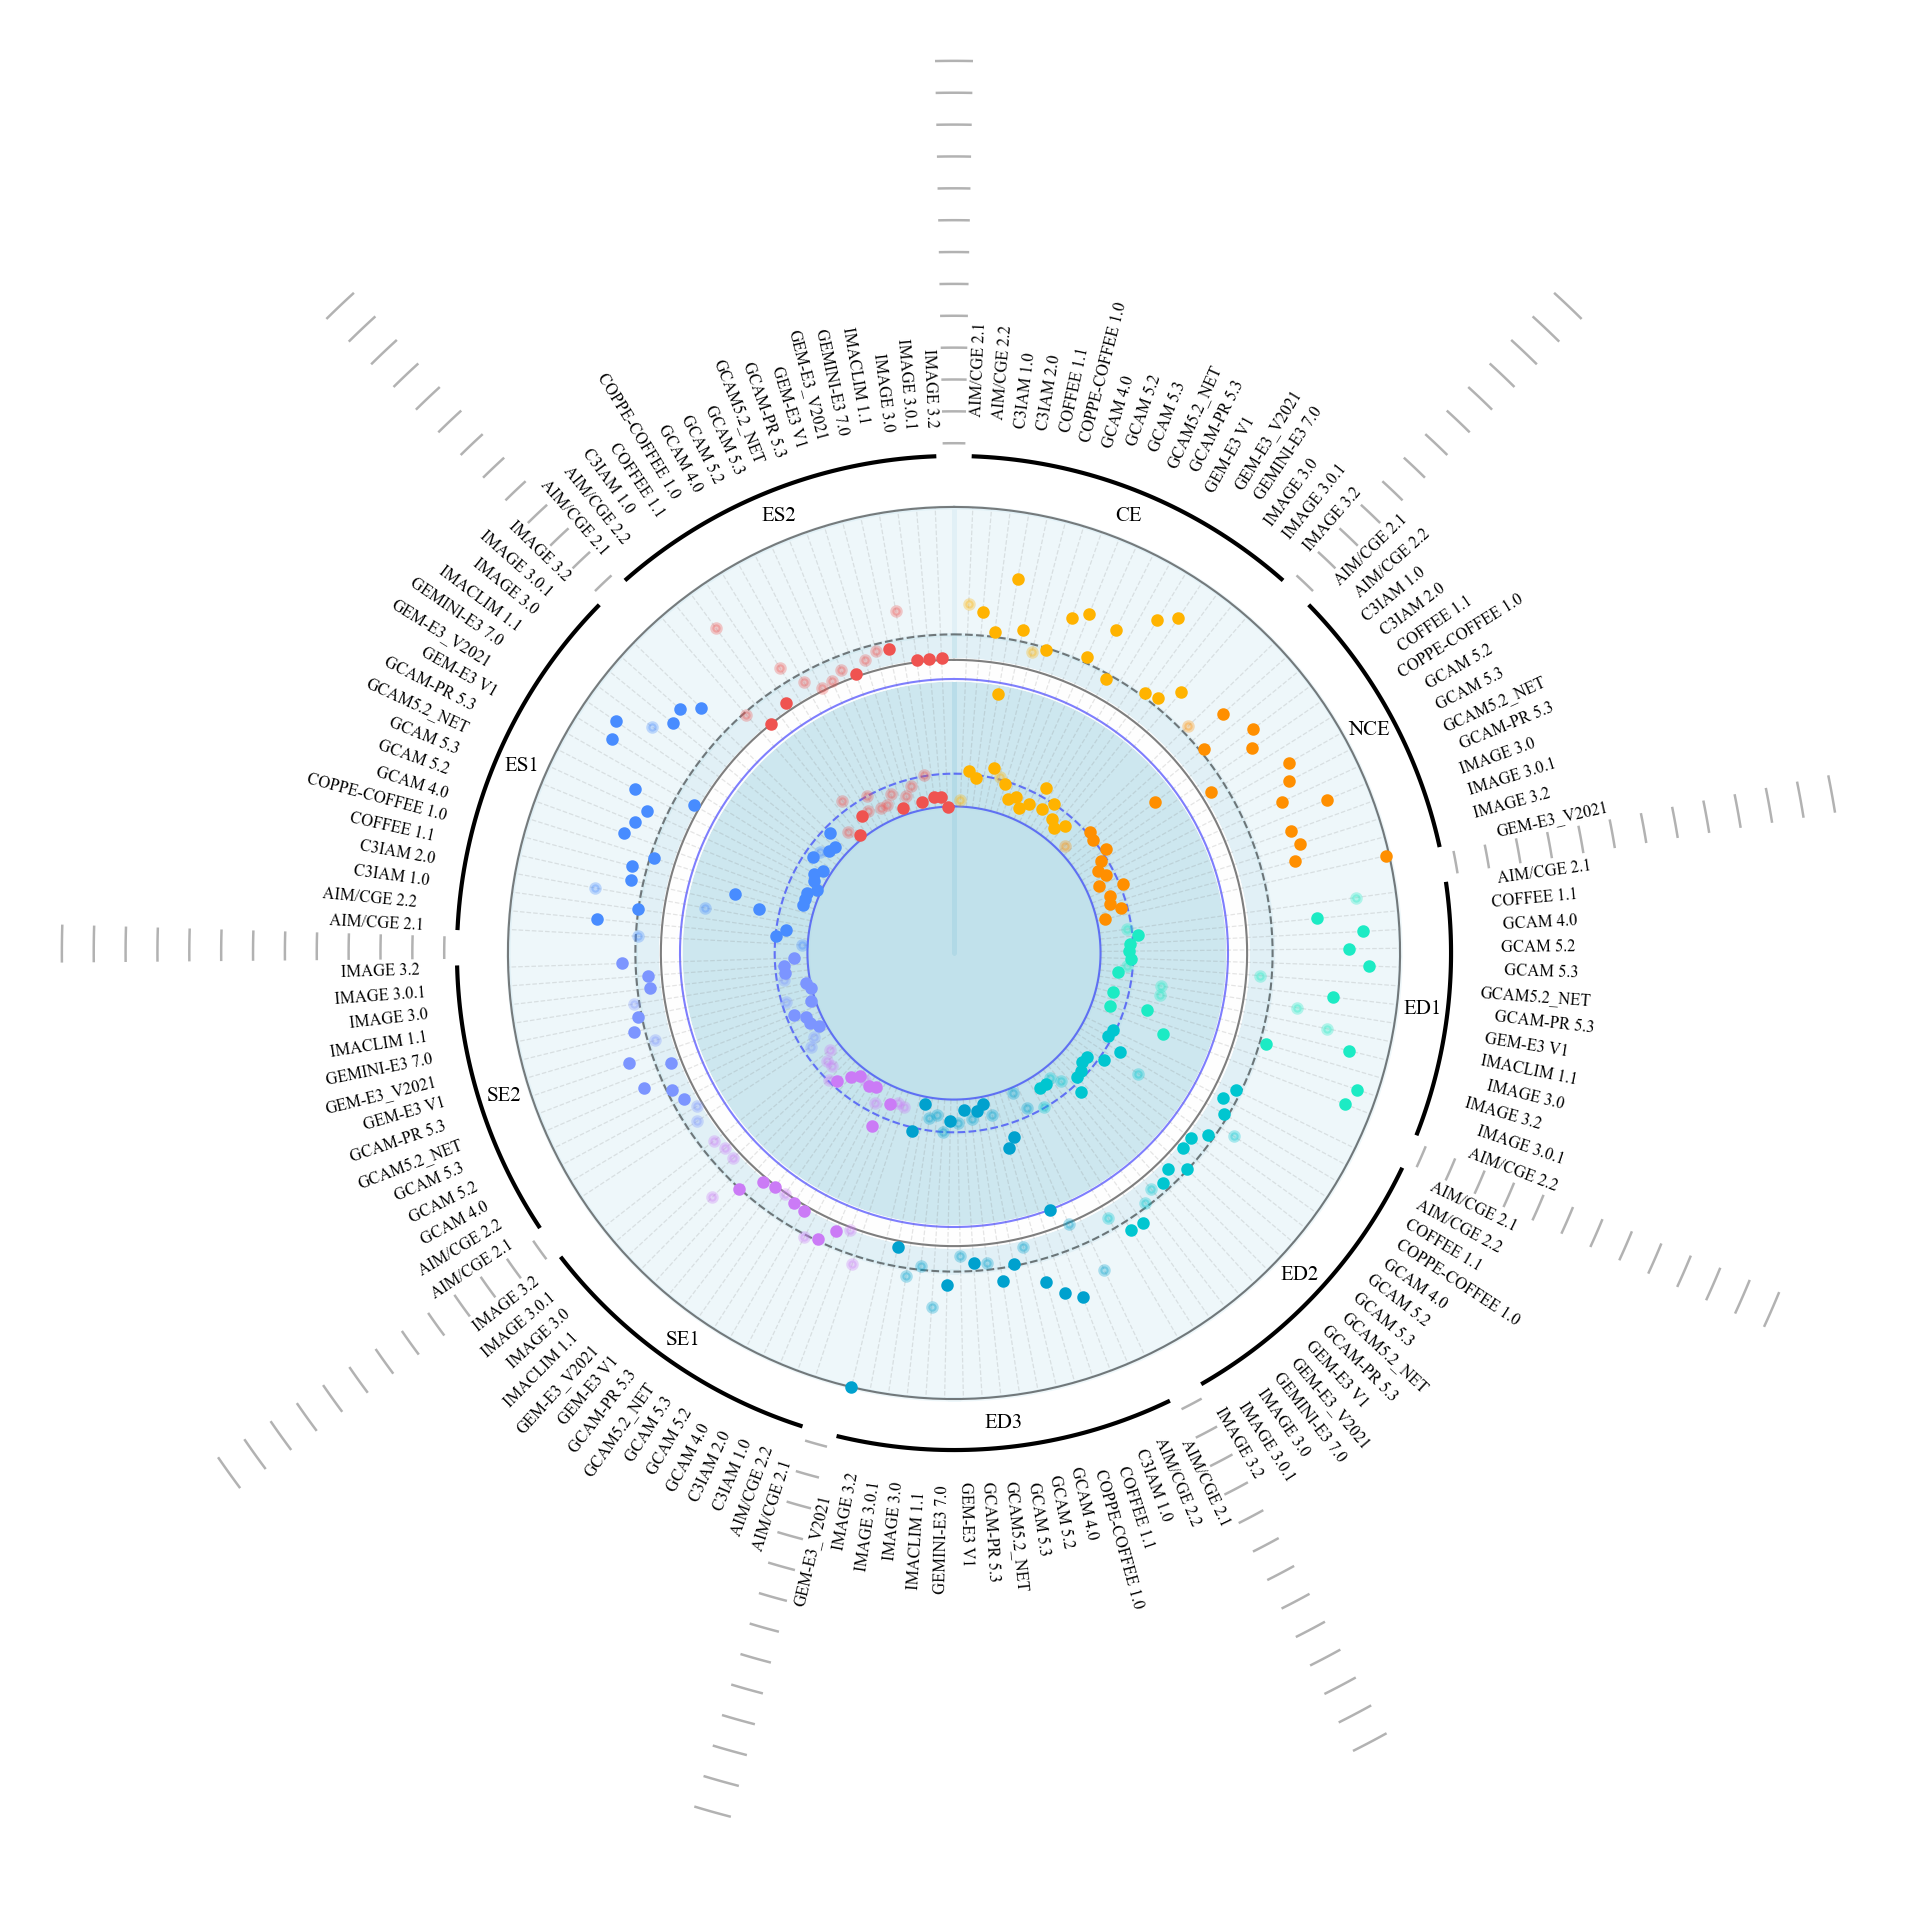

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

# -------------------------------------
# 1. 文件路径设置
# -------------------------------------
input_file = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\2_10-20历史RMSE计算\data\calculated_data\Normal_Centered_RMSE\非极度偏倚\模型输入的历史误差_非极度偏倚_画图.csv"
output_data_file = r'C:\Users\phc\Desktop\中国模型比较\中国模型比较2\2_10-20历史RMSE计算\results\Normal_Centered_RMSE\模型输入的历史误差极坐标散点图.csv'
output_fig_file  = r'C:\Users\phc\Desktop\中国模型比较\中国模型比较2\2_10-20历史RMSE计算\results\Normal_Centered_RMSE\模型输入的历史误差极坐标散点图.svg'

# -------------------------------------
# 2. 读取数据并设置全局字体
# -------------------------------------
plt.rc('font', family='Times New Roman')        # 全局字体
df = pd.read_csv(input_file)                   # 读取 CSV

# -------------------------------------
# 3. 定义分组变量及配色、组名
# -------------------------------------
variables = [
    "Emissions|CO2",
    "Emissions|Kyoto Gases",
    "Final Energy|Industry",
    "Final Energy|Residential and Commercial",
    "Final Energy|Transportation",
    "GDP|MER",
    "Population",
    "Primary Energy",
    "Secondary Energy|Electricity"
]
# 每个变量对应的颜色和简称
group_colors = ['#FFB300', '#FF8F00', '#1CEBC4', '#00C6D0', '#00A1CE',
                '#cb7bf6', '#7C95FF', '#488CFF', '#EF5350']
group_names  = ["CE", "NCE", "ED1", "ED2", "ED3", "SE1", "SE2", "ES1", "ES2"]

# -------------------------------------
# 4. 按变量分组，提取模型名、偏差、RMSE、中心化RMSE
# -------------------------------------
model_groups  = []  # 存储每组的模型名称列表
bias_groups   = []  # 存储每组的 NORMAL_bias 列表
rmse_groups   = []  # 存储每组的 NORMAL_RMSE 列表
crmse_groups  = []  # 存储每组的 C_NORMAL_RMSE 列表
for var in variables:
    sub = df[df['Variable'] == var]
    model_groups.append(sub['Model'].tolist())
    bias_groups.append(sub['NORMAL_bias'].tolist())
    rmse_groups.append(sub['NORMAL_RMSE'].tolist())
    crmse_groups.append(sub['C_NORMAL_RMSE'].tolist())

# -------------------------------------
# 5. 扁平化第二层、第三层数据，准备映射
# -------------------------------------
flat_rmse  = [val for group in rmse_groups  for val in group]
flat_crmse = [val for group in crmse_groups for val in group]

# 辅助函数：线性映射到指定区间
def map_values_to_range(values, min_v, max_v):
    arr = np.array(values, dtype=float)
    return min_v + (max_v - min_v) * (arr - arr.min()) / (arr.max() - arr.min())

mapped1_vals = map_values_to_range(flat_rmse, 46, 70)  # 第二层散点映射
mapped2_vals = map_values_to_range(flat_crmse, 23, 43)  # 第三层散点映射

# -------------------------------------
# 6. 构造占位列表：radii、colors、labels、mapped1、mapped2
#    保证每个 theta 位置都有对应的属性
# -------------------------------------
radii, colors, labels, mapped1, mapped2 = [], [], [], [], []
flat_idx = 0  # 用于遍历 mapped*_vals
for models, biases, rmse_list, crmse_list, color in zip(
        model_groups, bias_groups, rmse_groups, crmse_groups, group_colors):
    # 每组前添加一个分隔符（r=0）, 用于绘制刻度线
    radii.append(0)
    colors.append('white')
    labels.append(None)
    mapped1.append(None)
    mapped2.append(None)
    # 组内模型循环
    for model, bias, _rmse, _crmse in zip(models, biases, rmse_list, crmse_list):
        # 半径采用偏差绝对值
        radii.append(abs(bias))
        # 存储模型名用于标签
        labels.append(model)
        # 根据偏差正负调整透明度
        if bias < 0:
            r, g, b = matplotlib.colors.to_rgb(color)
            colors.append((r, g, b, 0.3))  # 负偏差半透明
        else:
            colors.append(color)
        # 对应位置存入映射后的散点值
        mapped1.append(mapped1_vals[flat_idx])
        mapped2.append(mapped2_vals[flat_idx])
        flat_idx += 1
# 如果末尾仍是分隔符，则移除
if radii and radii[-1] == 0:
    radii.pop(); colors.pop(); labels.pop(); mapped1.pop(); mapped2.pop()
assert flat_idx == len(mapped1_vals), "映射数据长度不一致"

# -------------------------------------
# 7. 极坐标参数配置
# -------------------------------------
N = len(radii)  # 总刻度点数
theta = np.linspace(0, 2*np.pi, N, endpoint=False)
# 考虑每组一个额外间隔，柱宽计算时加上 len(variables)
width      = 2 * np.pi / (N + len(variables))
bottom     = 80        # 环形基底
scale_lim  = 60        # 刻度范围
scale_major= 5         # 刻度步长

# -------------------------------------
# 8. 初始化画布与极坐标轴
# -------------------------------------
fig = plt.figure(figsize=(8, 8), dpi=300)
ax  = fig.add_subplot(projection='polar')
ax.set_theta_zero_location('N')  # 0° 北方
ax.set_theta_direction(-1)        # 逆时针

# -------------------------------------
# 9. 绘制径向刻度线与数值分隔符
# -------------------------------------
s_list = []  # 存放各组起始角度
for t, r in zip(theta, radii):
    if r == 0:
        s_list.append(t)
        t_vals = np.linspace(t - width/2, t + width/2, 6)
        # 绘制每个刻度线
        for i in range(bottom, bottom + scale_lim + scale_major, scale_major):
            ax.plot(t_vals, [i] * len(t_vals), color='gray', lw=0.6, alpha=0.6)
        # 在起始位置绘制数值标签
s_list.append(2 * np.pi)

# -------------------------------------
# 10. 绘制两层散点并放置模型文本标签
# -------------------------------------
for angle, rad, m1, m2, col, lbl in zip(theta, radii, mapped1, mapped2, colors, labels):
    if rad != 0:
        # 第一层散点
        ax.scatter(angle, m1, color=col, s=4, zorder=3)
        # 第二层散点
        ax.scatter(angle, m2, color=col, s=4, zorder=3)
        # 文本标签
        deg = np.rad2deg(angle)
        ax.text(
            angle,
            rad + bottom + scale_major * 0.5,
            lbl,
            fontsize=4,
            rotation=(90 - deg) if angle < np.pi else (270 - deg),
            rotation_mode='anchor',
            ha='left' if angle < np.pi else 'right',
            va='center'
        )

# -------------------------------------
# 11. 绘制环形分界线和背景填充
# -------------------------------------
theta_sep = np.linspace(0, 2*np.pi, 200)
r_vals    = [46, 50, 70, 43, 28.14, 23]
styles    = ['-', '--', '-', '-', '--', '-']
cols      = ['black', 'black', 'black', 'blue', 'blue', 'blue']
for r_sep, ls, lc in zip(r_vals, styles, cols):
    ax.plot(theta_sep, np.full_like(theta_sep, r_sep), linestyle=ls, color=lc, lw=0.5, alpha=0.5)
    ax.fill_between(theta_sep, 43, 46, color='white', alpha=0.8)
    ax.fill_between(theta_sep, 0, r_sep, color='lightblue', alpha=0.2)

# -------------------------------------
# 12. 绘制组名与底部分割线
# -------------------------------------
for i in range(len(s_list) - 1):
    t_mid = (s_list[i] + s_list[i + 1]) / 2
    xs = np.linspace(s_list[i] + width, s_list[i + 1] - width, 50)
    ys = np.full_like(xs, bottom - scale_major * 0.4)
    ax.plot(xs, ys, color='black', lw=1)
    ax.text(t_mid, bottom - scale_major * 1.2, group_names[i], fontsize=5, ha='center', va='center')

# -------------------------------------
# 13. 绘制辅助连接线并隐藏坐标轴
# -------------------------------------
for angle, rad in zip(theta, radii):
    if rad != 0:
        ax.plot([angle, angle], [23, 70], linestyle='--', color='grey', lw=0.3, alpha=0.2)
ax.set_rlim(0, bottom + scale_lim + scale_major)
ax.axis('off')

# -------------------------------------
# 14. 导出数据和保存图像
# -------------------------------------
pd.DataFrame({
    'Normalized Second Layer Data': mapped1,
    'Normalized Third Layer Data':  mapped2
}).to_csv(output_data_file, index=False, encoding='utf-8-sig')
plt.savefig(output_fig_file, format='svg', dpi=500, bbox_inches='tight')
plt.show()


## 能源供给类模型误差_能源系统模型误差(发电能力)

### 合并文件

In [10]:
import pandas as pd

# 路径
file1 = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\calculated_data\Normal_Centered_RMSE\非极度偏倚\能源供给类模型误差_能源系统模型误差(发电能力)_非偏倚.xlsx"
file2 = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\results\origin_results\rmse_results_models_average.csv"
output = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\二、RMSE计算\calculated_data\Normal_Centered_RMSE\非极度偏倚\能源供给类模型误差_能源系统模型误差(发电能力)_非偏倚_画图.csv"

# 读取数据
df1 = pd.read_excel(file1)
df2 = pd.read_csv(file2)

# 假设NORMAL_bias在df2中，如果不叫这个名字请用实际列名
# 合并，默认inner会保留两边都匹配的行，如果要保留左表全部，用left
merged = pd.merge(df1, df2[['Model', 'Variable', 'NORMAL_bias']], on=['Model', 'Variable'], how='left')

# 用df2的NORMAL_bias列替换df1的NORMAL_bias列（如果df1本来有这个列）
merged['NORMAL_bias'] = merged['NORMAL_bias_y'].combine_first(merged['NORMAL_bias_x'])
# 或者直接保留merge后的NORMAL_bias列
merged = merged.drop(columns=[col for col in merged.columns if col.endswith('_x') or col.endswith('_y')])

# 保存为csv
merged.to_csv(output, index=False, encoding='utf-8-sig')

### 画图

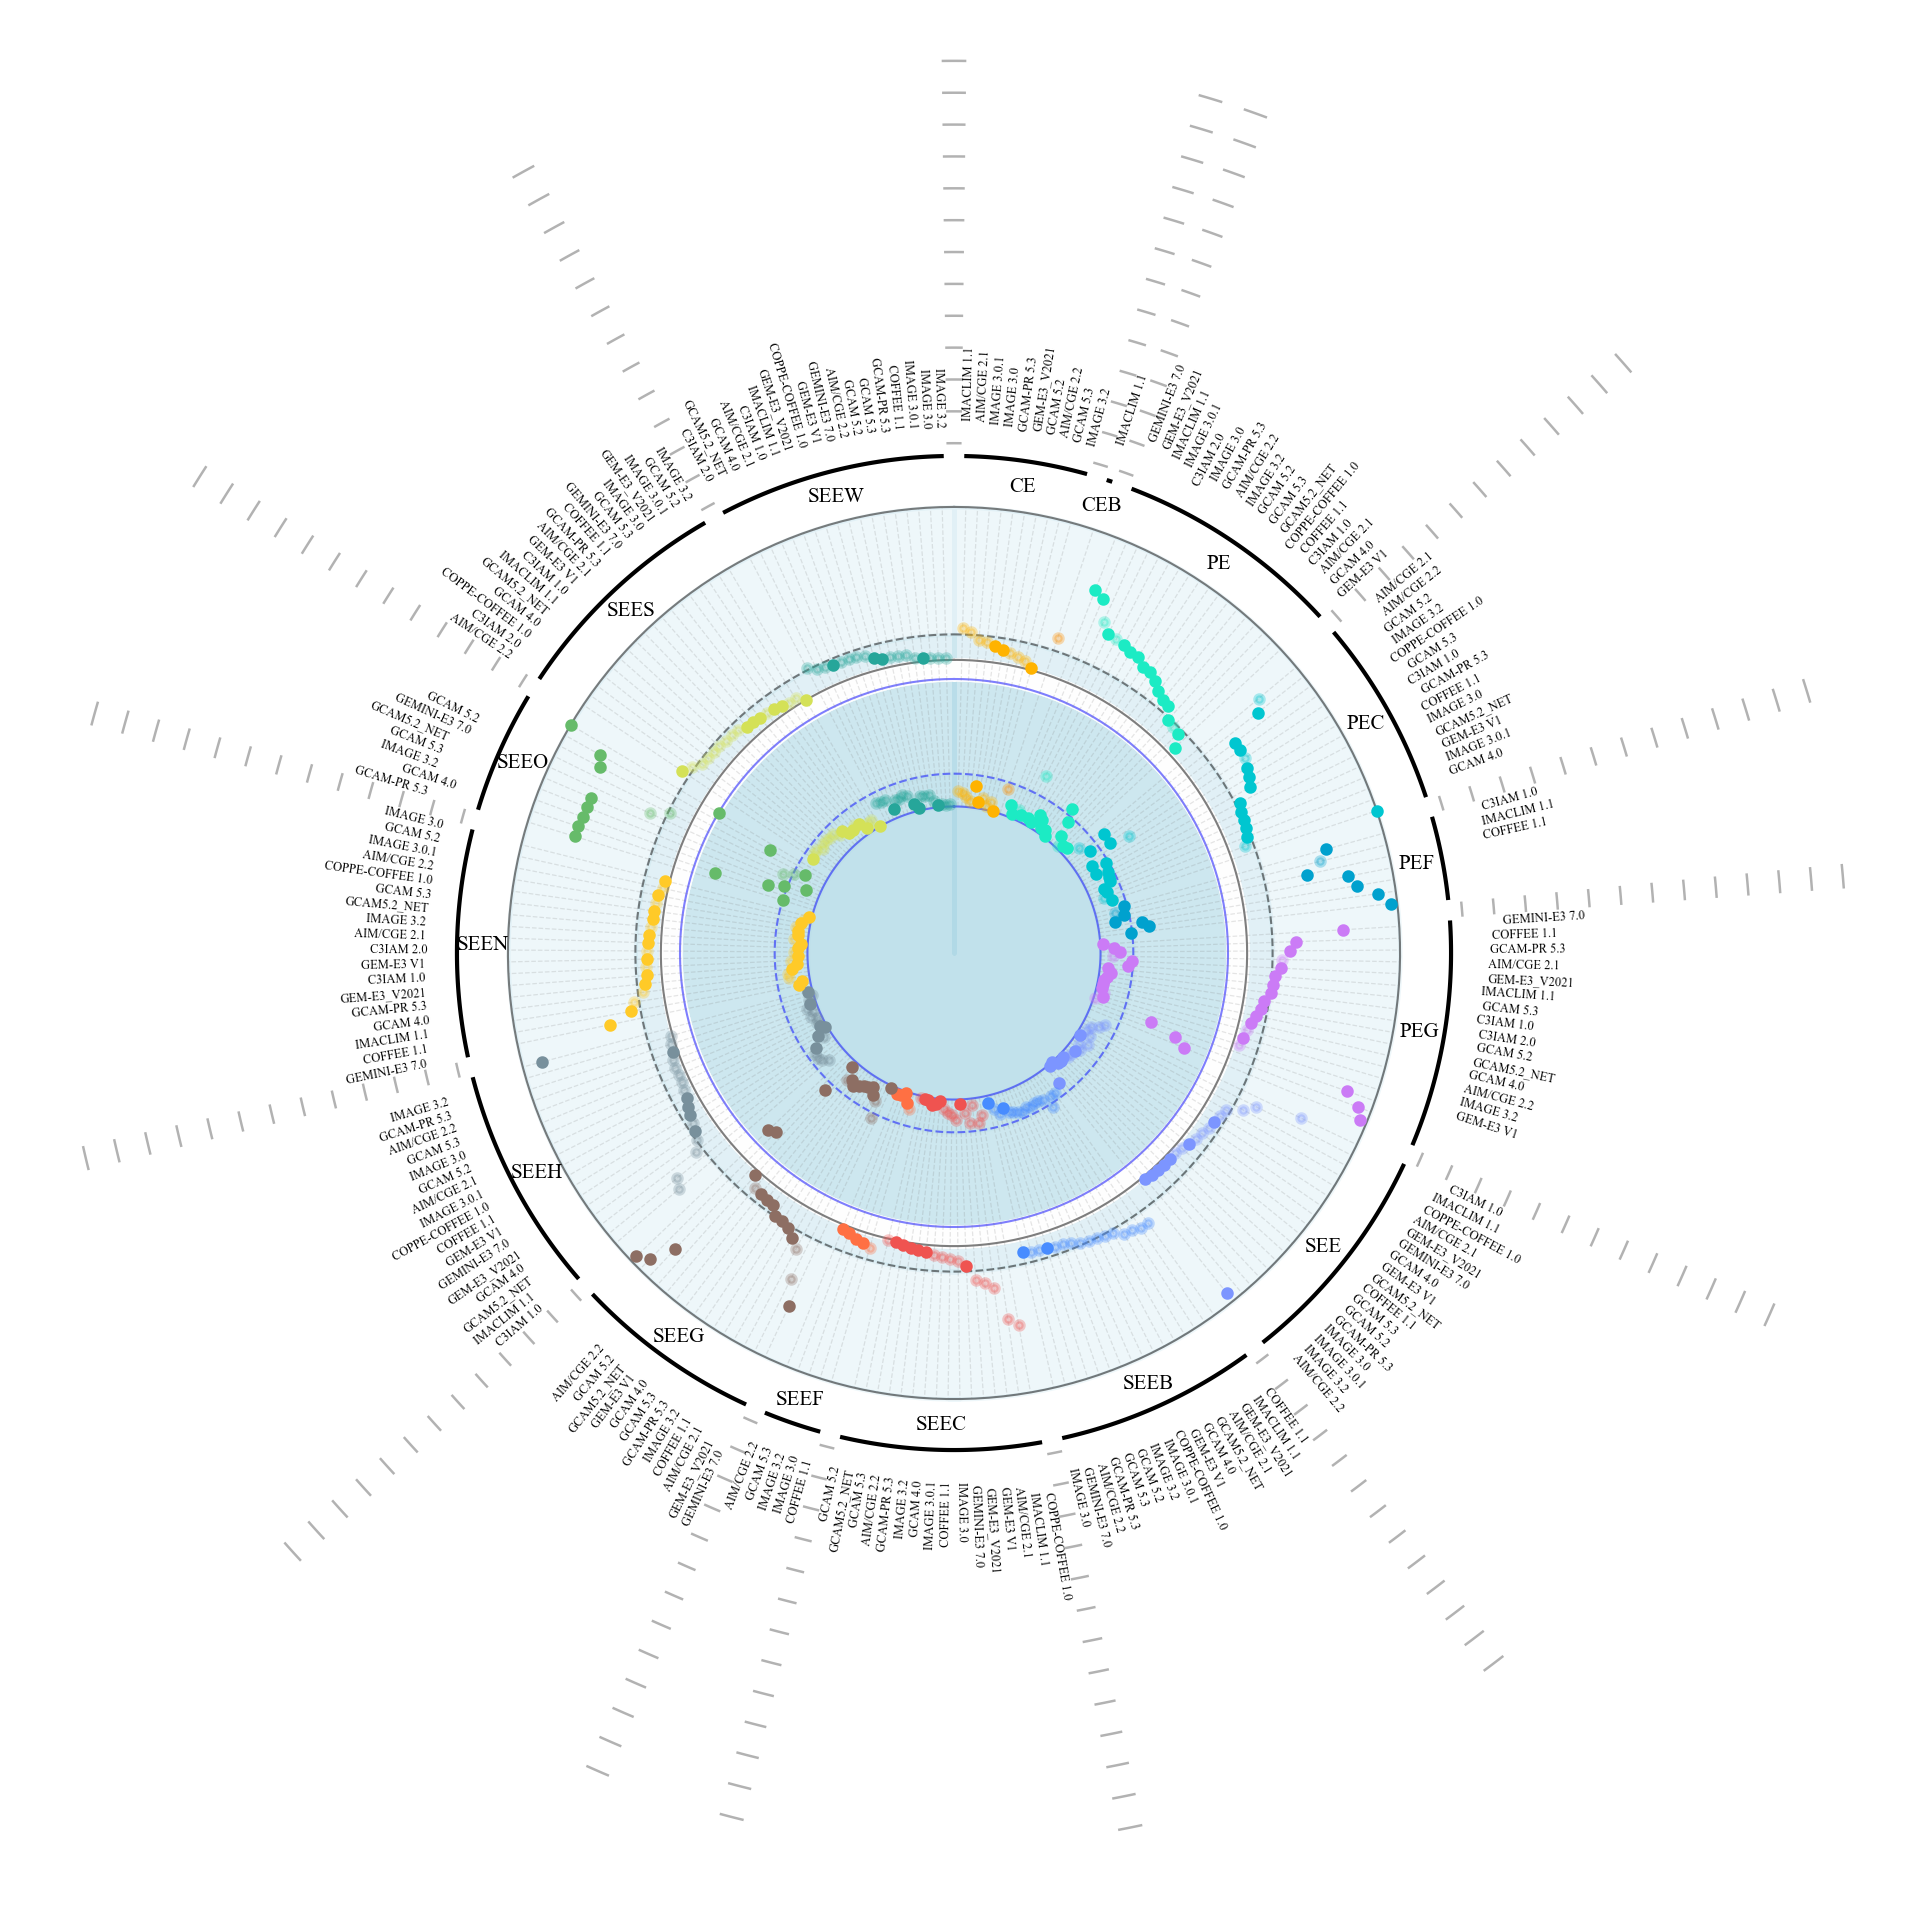

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

# -------------------------------------
# 1. 文件路径设置
# -------------------------------------
input_file = r"C:\Users\phc\Desktop\中国模型比较\中国模型比较2\2_10-20历史RMSE计算\data\calculated_data\Normal_Centered_RMSE\非极度偏倚\能源供给类模型误差_能源系统模型误差(发电能力)_非偏倚_画图.csv"
output_data_file = r'C:\Users\phc\Desktop\中国模型比较\中国模型比较2\2_10-20历史RMSE计算\results\Normal_Centered_RMSE\能源供给类模型误差_能源系统模型误差(发电能力)的历史误差极坐标散点图.csv'
output_fig_file  = r'C:\Users\phc\Desktop\中国模型比较\中国模型比较2\2_10-20历史RMSE计算\results\Normal_Centered_RMSE\能源供给类模型误差_能源系统模型误差(发电能力)的历史误差极坐标散点图.svg'

# -------------------------------------
# 2. 读取数据并设置全局字体
# -------------------------------------
plt.rc('font', family='Times New Roman')
df = pd.read_csv(input_file)

# -------------------------------------
# 3. 定义分组变量及配色、组名（16 组）
# -------------------------------------
variables = [
    "Capacity|Electricity",
    "Capacity|Electricity|Biomass",
    "Primary Energy",
    "Primary Energy|Coal",
    "Primary Energy|Fossil",
    "Primary Energy|Gas",
    "Secondary Energy|Electricity",
    "Secondary Energy|Electricity|Biomass",
    "Secondary Energy|Electricity|Coal",
    "Secondary Energy|Electricity|Fossil",
    "Secondary Energy|Electricity|Gas",
    "Secondary Energy|Electricity|Hydro",
    "Secondary Energy|Electricity|Nuclear",
    "Secondary Energy|Electricity|Oil",
    "Secondary Energy|Electricity|Solar",
    "Secondary Energy|Electricity|Wind"
]

group_colors = [
    '#FFB300', '#FF8F00', '#1CEBC4', '#00C6D0',
    '#00A1CE', '#CB7BF6', '#7C95FF', '#488CFF',
    '#EF5350', '#FF7043', '#8D6E63', '#78909C',
    '#FFCA28', '#66BB6A', '#D4E157', '#26A69A'
]

group_names = [
    "CE", "CEB", "PE", "PEC", "PEF", "PEG",
    "SEE", "SEEB", "SEEC", "SEEF", "SEEG", "SEEH",
    "SEEN", "SEEO", "SEES", "SEEW"
]

# -------------------------------------
# 4. 按变量分组，提取模型、偏差、RMSE、中心化RMSE
# -------------------------------------
model_groups = []
bias_groups  = []
rmse_groups  = []
crmse_groups = []

for var in variables:
    sub = df[df['Variable'] == var]
    model_groups.append(sub['Model'].tolist())
    bias_groups.append(sub['NORMAL_bias'].tolist())
    rmse_groups.append(sub['NORMAL_RMSE'].tolist())
    crmse_groups.append(sub['C_NORMAL_RMSE'].tolist())

# -------------------------------------
# 5. 扁平化第二/第三层数据以便映射
# -------------------------------------
flat_rmse  = [v for grp in rmse_groups  for v in grp]
flat_crmse = [v for grp in crmse_groups for v in grp]

def map_values_to_range(values, lo, hi):
    arr = np.array(values, dtype=float)
    return lo + (hi - lo) * (arr - arr.min()) / (arr.max() - arr.min())

mapped1_vals = map_values_to_range(flat_rmse, 46, 70)
mapped2_vals = map_values_to_range(flat_crmse, 23, 43)

# -------------------------------------
# 6. 构造占位列表：radii, colors, labels, mapped1, mapped2
#    保证 theta 上每个位置属性一一对应
# -------------------------------------
radii, colors, labels, mapped1, mapped2 = [], [], [], [], []
idx_flat = 0

# 这里不再 pop，而是用每次 zip 到的 rmse_list/crmse_list
for models, biases, rmse_list, crmse_list, color in zip(
        model_groups, bias_groups, rmse_groups, crmse_groups, group_colors):
    # 1) 插入一个分隔符占位（r=0）
    radii.append(0)
    colors.append('white')
    labels.append(None)
    mapped1.append(None)
    mapped2.append(None)

    # 2) 组内模型循环
    for mdl, bias, rmse_val, crm_val in zip(models, biases, rmse_list, crmse_list):
        # 半径占位：绝对偏差
        radii.append(abs(bias))
        # 模型名标签
        labels.append(mdl)
        # 颜色（负值半透明）
        if bias < 0:
            r, g, b = matplotlib.colors.to_rgb(color)
            colors.append((r, g, b, 0.3))
        else:
            colors.append(color)
        # 对应位置的映射值
        mapped1.append(mapped1_vals[idx_flat])
        mapped2.append(mapped2_vals[idx_flat])
        idx_flat += 1

# 3) 移除末尾多余的分隔符
if radii and radii[-1] == 0:
    radii.pop(); colors.pop(); labels.pop(); mapped1.pop(); mapped2.pop()

# 确认映射次数正确
assert idx_flat == len(mapped1_vals), f"映射长度不匹配: {idx_flat} vs {len(mapped1_vals)}"

# -------------------------------------
# 7. 极坐标参数设置
# -------------------------------------
N      = len(radii)
theta  = np.linspace(0, 2*np.pi, N, endpoint=False)
width  = 2 * np.pi / (N + len(variables))
bottom = 80
scale_lim   = 60
scale_major = 5

# -------------------------------------
# 8. 初始化画布 & 极坐标轴
# -------------------------------------
fig = plt.figure(figsize=(8, 8), dpi=300, facecolor='white')
ax  = fig.add_subplot(projection='polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# -------------------------------------
# 9. 绘制径向刻度线 & 分隔符记录
# -------------------------------------
s_list = []
for ang, rad in zip(theta, radii):
    if rad == 0:
        s_list.append(ang)
        t_vals = np.linspace(ang - width/2, ang + width/2, 6)
        for i in range(bottom, bottom + scale_lim + scale_major, scale_major):
            ax.plot(t_vals, [i]*len(t_vals), color='gray', lw=0.6, alpha=0.6)
s_list.append(2*np.pi)

# -------------------------------------
# 10. 两层散点 & 标签
# -------------------------------------
for ang, rad, m1, m2, col, lbl in zip(theta, radii, mapped1, mapped2, colors, labels):
    if rad != 0:
        ax.scatter(ang, m1, color=col, s=4, zorder=3)
        ax.scatter(ang, m2, color=col, s=4, zorder=3)
        deg = np.rad2deg(ang)
        ax.text(
            ang,
            rad + bottom + scale_major*0.5,
            lbl,
            fontsize=3,
            rotation=(90 - deg) if ang < np.pi else (270 - deg),
            rotation_mode='anchor',
            ha='left' if ang < np.pi else 'right',
            va='center'
        )

# -------------------------------------
# 11. 环形分界 & 填充
# -------------------------------------
theta_sep = np.linspace(0, 2*np.pi, 200)
r_vals    = [46, 50, 70, 43, 28.14, 23]
styles    = ['-', '--', '-', '-', '--', '-']
cols      = ['black','black','black','blue','blue','blue']
for rv, ls, lc in zip(r_vals, styles, cols):
    ax.plot(theta_sep, [rv]*len(theta_sep), linestyle=ls, color=lc, lw=0.5, alpha=0.5)
    ax.fill_between(theta_sep, 43, 46, color='white', alpha=0.8)
    ax.fill_between(theta_sep, 0,  rv, color='lightblue', alpha=0.2)

# -------------------------------------
# 12. 组名 & 底部横线
# -------------------------------------
for i in range(len(s_list)-1):
    t_mid = (s_list[i] + s_list[i+1]) / 2
    xs    = np.linspace(s_list[i]+width, s_list[i+1]-width, 50)
    ys    = [bottom - scale_major*0.4]*50
    ax.plot(xs, ys, color='black', lw=1)
    ax.text(t_mid, bottom - scale_major*1.2, group_names[i],
            ha='center', va='center', fontsize=5)

# -------------------------------------
# 13. 辅助线 & 关闭刻度轴
# -------------------------------------
for ang, rad in zip(theta, radii):
    if rad != 0:
        ax.plot([ang, ang], [23, 70], '--', color='grey', lw=0.3, alpha=0.2)

ax.set_rlim(0, bottom + scale_lim + scale_major)
ax.set_xticks([])   # 取消角度刻度标签
ax.set_yticks([])   # 取消半径刻度标签
ax.axis('off')

# -------------------------------------
# 14. 导出数据 & 保存图像
# -------------------------------------
pd.DataFrame({
    'Normalized Second Layer Data': mapped1,
    'Normalized Third Layer Data' : mapped2
}).to_csv(output_data_file, index=False, encoding='utf-8-sig')

plt.savefig(output_fig_file, format='svg', dpi=500, bbox_inches='tight')
plt.show()
